## Imports
This must be run

In [ ]:
!pip install s3fs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 26.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.


In [ ]:
!gdown 1Zyj0fvbzE8fBmmrqzQemcMh4Yhr6I3YD
!gdown 1-eb8dbgukvtKjtNJM2mCp-mXJW_AtcFJ
!gdown 1-0HkeoKG3kpqbFELN_I2gKsfugF7OumL

In [ ]:
import pandas as pd
import random
import os
import s3fs

import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import preprocessing

### Utils

In [ ]:
def money_savings(outputs):
    elec_cons = outputs[:, 22:32]
    gas_cons = outputs[:, 32:]
    # Average data in 2023
    elec_price = 0.2338 #$/kwh
    gas_price = 0.07 #$/kwh
    return (elec_cons[:, :-1]-elec_cons[:, 1:])*elec_price + (gas_cons[:, :-1]-gas_cons[:, 1:])*gas_price

def median_abs_percent_error(outputs, true_values):
    # Avoid division by zero error
    true_values = true_values + 1e-8
    percent_errors = torch.abs((outputs - true_values) / true_values) * 100
    return torch.median(percent_errors)

def mean_abs_error(outputs, true_values):
    outputs = outputs * torch.std(torch_y) + torch.mean(torch_y)
    percent_errors = torch.abs((outputs - true_values))
    return torch.mean(percent_errors)

In [ ]:
X1 = np.load('X1.npy')
X2 = np.load('X2.npy')
Y = np.load('Y.npy')

## Metadata

This takes ~2 minutes to download. Skip forward to Results if desired

In [ ]:
columns_to_keep = [
    'in.building_america_climate_zone', 'in.county', 'in.state', 'in.weather_file_city', 'in.geometry_building_type_recs',

    'out.electricity.total.lrmer_95_decarb_by_2035_15_2025_start.co2e_kg',
    'out.natural_gas.total.lrmer_95_decarb_by_2035_15_2025_start.co2e_kg',

    'out.electricity.total.lrmer_low_re_cost_15_2025_start.co2e_kg',
    'out.natural_gas.total.lrmer_low_re_cost_15_2025_start.co2e_kg',

    'out.electricity.total.lrmer_low_re_cost_25_2025_start.co2e_kg',
    'out.natural_gas.total.lrmer_low_re_cost_25_2025_start.co2e_kg',

    'out.electricity.total.lrmer_mid_case_15_2025_start.co2e_kg',
    'out.natural_gas.total.lrmer_mid_case_15_2025_start.co2e_kg',

    'out.electricity.total.energy_consumption',
    'out.natural_gas.total.energy_consumption',
]

Downloading baseline metadata

In [ ]:
base_url_1_1 = 'https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_amy2018_release_1.1/'
state = "MA"

# Get Baseline Metadata for all buildings in MA
upgrade = 0
upgrade_str = 'baseline' if upgrade==0 else f'upgrade{upgrade:02d}'
df_metadata_baseline = pd.read_parquet(f'{base_url_1_1}metadata/{upgrade_str}.parquet', filters=[('in.state','==',state)])
df_metadata_baseline = df_metadata_baseline[columns_to_keep]

In [ ]:
df_metadata_baseline.columns.to_list()

['in.building_america_climate_zone',
 'in.county',
 'in.state',
 'in.weather_file_city',
 'in.geometry_building_type_recs',
 'out.electricity.total.lrmer_95_decarb_by_2035_15_2025_start.co2e_kg',
 'out.natural_gas.total.lrmer_95_decarb_by_2035_15_2025_start.co2e_kg',
 'out.electricity.total.lrmer_low_re_cost_15_2025_start.co2e_kg',
 'out.natural_gas.total.lrmer_low_re_cost_15_2025_start.co2e_kg',
 'out.electricity.total.lrmer_low_re_cost_25_2025_start.co2e_kg',
 'out.natural_gas.total.lrmer_low_re_cost_25_2025_start.co2e_kg',
 'out.electricity.total.lrmer_mid_case_15_2025_start.co2e_kg',
 'out.natural_gas.total.lrmer_mid_case_15_2025_start.co2e_kg',
 'out.electricity.total.energy_consumption',
 'out.natural_gas.total.energy_consumption']

Dictionaries to determine all distinct zones, cities, states, weathers, geometries.

In [ ]:
# X1 = ['out.electricity.total.energy_consumption', 'out.natural_gas.total.energy_consumption']
X2 = ['in.building_america_climate_zone', 'in.county', 'in.state', 'in.weather_file_city', 'in.geometry_building_type_recs']
X2_ = {'in.building_america_climate_zone':[], 'in.county':[], 'in.state':[], 'in.weather_file_city':[], 'in.geometry_building_type_recs':[]}
for x2 in X2:
  try:
    Y = df_metadata_baseline[x2]
    for i in Y:
      if i not in X2_[x2]:
        X2_[x2].append(i)
  except:
    print('NA')

print([len(i) for i in X2_.values()])

print(X2_)

[1, 14, 1, 13, 5]
{'in.building_america_climate_zone': ['Cold'], 'in.county': ['G2500050', 'G2500010', 'G2500250', 'G2500090', 'G2500210', 'G2500130', 'G2500150', 'G2500270', 'G2500170', 'G2500230', 'G2500030', 'G2500070', 'G2500110', 'G2500190'], 'in.state': ['MA'], 'in.weather_file_city': ['Taunton Muni', 'Barnstable Muni Boa', 'Boston Logan Intl', 'Beverly Muni', 'Norwood Mem', 'Chicopee Falls West', 'Worcester Regional Arpt', 'Laurence G Hanscom', 'Plymouth Municipal', 'Harriman And West', 'Marthas Vineyard', 'Dillant Hopkins', 'Nantucket Mem'], 'in.geometry_building_type_recs': ['Single-Family Detached', 'Multi-Family with 2 - 4 Units', 'Single-Family Attached', 'Multi-Family with 5+ Units', 'Mobile Home']}


downloading simulated upgrades metadata

In [ ]:
upgraded_meta = []
for upgrade in tqdm(range(1,11)):
    upgrade_str = 'baseline' if upgrade==0 else f'upgrade{upgrade:02d}'
    df_nrel_metadata = pd.read_parquet(f'{base_url_1_1}metadata/{upgrade_str}.parquet', filters=[('in.state','==',state)])
    df_nrel_metadata = df_nrel_metadata[columns_to_keep]
    upgraded_meta.append(df_nrel_metadata)

## Full Data Construction
This takes ~90 minutes to download. Skip forward to Results if desired

downloads the first `num_files` building's current loadshapes

In [ ]:
# Create a S3 file system object
fs = s3fs.S3FileSystem(anon=True)

dataset = pd.DataFrame()
#dataframes_y = []

columns_to_keep_x = [
    'out.electricity.total.energy_consumption',
    'out.natural_gas.total.energy_consumption'
]

# Define the S3 bucket and path
bucket = 'oedi-data-lake'
path = 'nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_amy2018_release_1.1/timeseries_individual_buildings/by_state/upgrade=0/state=MA/'

# List all the files in the specified directory
files = fs.ls(f'{bucket}/{path}')

# Download and read the parquet files
X1 = []
ID = []

num_files = 5000 # 0 = all files
n = 1
random.shuffle(files)

for file in tqdm(files):
    id = file.split('/')[-1].split('-')[0]
    ID.append(id)
    with fs.open(f's3://{file}') as f:
        df = pd.read_parquet(f)
        df = df[columns_to_keep_x]
        #matrix of the hourly loadshapes
        M = []
        A = np.array(df[columns_to_keep_x[0]])
        A = A.reshape(-1, 4)
        A = np.average(A, 1)
        M.append(A)

        B = np.array(df[columns_to_keep_x[1]])
        B = B.reshape(-1, 4)
        B = np.average(B, 1)
        M.append(B)

        M = np.array(M)
        M=M.transpose()
        X1.append(M)

    n+=1
    if n==num_files:
        break

dataset['ID']=ID
dataset['X1']=X1

 43%|████▎     | 4998/11690 [1:26:55<1:56:22,  1.04s/it]


In [ ]:
id_arr = np.array(ID)

# save np array
np.save('/content/drive/My Drive/id_arr.npy', id_arr)

(4999,)


mapping the dictionaries from earlier to indices for one-hot/binary encoding

In [ ]:
category_mapping = {
    'in.county': {county: idx for idx, county in enumerate(X2_['in.county'])},
    'in.weather_file_city': {city: idx+14 for idx, city in enumerate(X2_['in.weather_file_city'])},
    'in.geometry_building_type_recs': {building_type: idx+27 for idx, building_type in enumerate(X2_['in.geometry_building_type_recs'])}
}

one-hot encoding

In [ ]:
X2 = []
Y = []

for id in dataset['ID']:
    arr = np.zeros(32)
    record = df_metadata_baseline.loc[int(id)]

    # Set the bits for one-hot encoding
    if record['in.county'] in category_mapping['in.county']:
        arr[category_mapping['in.county'][record['in.county']]] = 1

    if record['in.weather_file_city'] in category_mapping['in.weather_file_city']:
        arr[category_mapping['in.weather_file_city'][record['in.weather_file_city']]] = 1

    if record['in.geometry_building_type_recs'] in category_mapping['in.geometry_building_type_recs']:
        arr[category_mapping['in.geometry_building_type_recs'][record['in.geometry_building_type_recs']]] = 1

    X2.append(arr)

    # Extract Y values
    elec = record['out.electricity.total.lrmer_mid_case_15_2025_start.co2e_kg']
    gas = record['out.natural_gas.total.lrmer_mid_case_15_2025_start.co2e_kg']
    temp = np.array([elec, gas])

    for i in range(1, 11):
        elec = upgraded_meta[i-1].loc[int(id)]['out.electricity.total.lrmer_mid_case_15_2025_start.co2e_kg']
        gas = upgraded_meta[i-1].loc[int(id)]['out.natural_gas.total.lrmer_mid_case_15_2025_start.co2e_kg']
        elec2 = upgraded_meta[i-1].loc[int(id)]['out.electricity.total.energy_consumption']
        gas2 = upgraded_meta[i-1].loc[int(id)]['out.natural_gas.total.energy_consumption']
        temp = np.append(temp, [elec, gas, elec2, gas2])

    Y.append(temp)

# Adding to the dataset
dataset['X2'] = X2
dataset['Y'] = Y

In [ ]:
# Convert the pandas columns to numpy arrays
X1 = np.array(dataset['X1'].to_list())
X2 = np.array(dataset['X2'].to_list())
Y = np.array(dataset['Y'].to_list())

In [ ]:
X1.shape, X2.shape, Y.shape

((4999, 8760, 2), (4999, 32), (4999, 42))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/X1.npy'
np.save(file_path, X1)

In [ ]:
np.save('/content/drive/My Drive/X2.npy', X2)
np.save('/content/drive/My Drive/Y.npy', Y)

## ML Model Setup

In [ ]:
# Model parameters
n = 8760
m = 32
t = 22 + 20

batch_size = 256

# Generate random training vector
# x1_basic = torch.randn(2, n)
# x2_basic = torch.randn(m)

Define Model

In [ ]:
class CarbonReductionCNN(nn.Module):
    def __init__(self):
        super(CarbonReductionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=5)
        # Try playing around with pooling size
        self.p = 2
        self.pool = nn.MaxPool1d(kernel_size=self.p)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5)
        # Adjust the input size based on your data
        self.fc1 = nn.Linear(128 * (((n // self.p - self.p) // self.p) - self.p) + m, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, t)

    def forward(self, x1, x2):
        x = self.pool(F.relu(self.conv1(x1)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(torch.hstack([x, x2])))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output_layer(x)
        return x

"""
# Example usage (assuming you have training data X_train, y_train)
X1_train = torch.randn((batch_size, 2, n))  # Replace with your actual data
X2_train = torch.randn((batch_size, m))
y_train = torch.randn((batch_size, t))  # Replace with your actual labels
model(X1_train, X2_train, y_train)
"""

'\n# Example usage (assuming you have training data X_train, y_train)\nX1_train = torch.randn((batch_size, 2, n))  # Replace with your actual data\nX2_train = torch.randn((batch_size, m))\ny_train = torch.randn((batch_size, t))  # Replace with your actual labels\nmodel(X1_train, X2_train, y_train)\n'

Split Data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X1_normed = (X1 - np.mean(X1)) / np.std(X1)
X2_normed = (X2 - np.mean(X2)) / np.std(X2)
Y_normed = (Y - np.mean(Y)) / np.std(Y)

# Y_normed = Y_normed[:, :22]

torch_y = torch.tensor(Y, dtype=torch.float32).to(device)

x1_data = np.swapaxes(X1_normed, 1, 2)
x2_data = X2_normed
y_data = Y_normed

x1_data = torch.tensor(x1_data, dtype=torch.float32).to(device)
x2_data = torch.tensor(x2_data, dtype=torch.float32).to(device)
y_data = torch.tensor(y_data, dtype=torch.float32).to(device)

class CustomDataset(Dataset):
    def __init__(self, x1, x2, y):
        self.x1 = x1
        self.x2 = x2
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x1[idx], self.x2[idx], self.y[idx]

torch.manual_seed(42)
# Assuming x1, x2, and y are lists of tuples
# Create a dataset and split it into training and testing sets
dataset = CustomDataset(x1_data, x2_data, y_data)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Train Model

In [ ]:
num_epochs = 50

# Instantiate the model
model = CarbonReductionCNN()
model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Assuming a classification task
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjust the learning rate as needed
hist_test = []
hist_train = []

meds_train = []
meds_test = []

for epoch in range(num_epochs):
    train_loss = 0
    train_percent_med = 0
    model.train()
    # train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)')
    for x1_batch, x2_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x1_batch, x2_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_percent_med += median_abs_percent_error(outputs, y_batch).item()
        # train_pbar.set_postfix({'Loss': loss.item()})

    meds_train.append(train_percent_med / len(train_loader))
    hist_train.append(train_loss / len(train_loader))

    if epoch % 10 == 0: print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader)}')

    # test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Test)')
    test_loss = 0
    test_percent_med = 0
    # Validation loop
    with torch.no_grad():
        model.eval()
        for x1_batch, x2_batch, y_batch in test_loader:
            outputs = model(x1_batch, x2_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            test_percent_med += median_abs_percent_error(outputs, y_batch).item()
            # test_pbar.set_postfix({'Loss': loss.item()})

        meds_test.append(test_percent_med / len(test_loader))
        hist_test.append(test_loss / len(test_loader))
        model.train()

        if epoch % 10 == 0: print(f'Epoch: {epoch+1}/{num_epochs}, Test Loss: {test_loss / len(test_loader)}')

Epoch: 1/50, Train Loss: 0.6249014902859926
Epoch: 1/50, Test Loss: 0.49037086963653564
Epoch: 101/50, Train Loss: 0.09124844614416361
Epoch: 11/50, Test Loss: 0.1003301702439785
Epoch: 201/50, Train Loss: 0.06959133897908032
Epoch: 21/50, Test Loss: 0.08772844448685646
Epoch: 301/50, Train Loss: 0.04833680228330195
Epoch: 31/50, Test Loss: 0.07758166920393705
Epoch: 401/50, Train Loss: 0.030758562148548663
Epoch: 41/50, Test Loss: 0.06727543380111456


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/Penn/CarbonReductionCNN.pth')

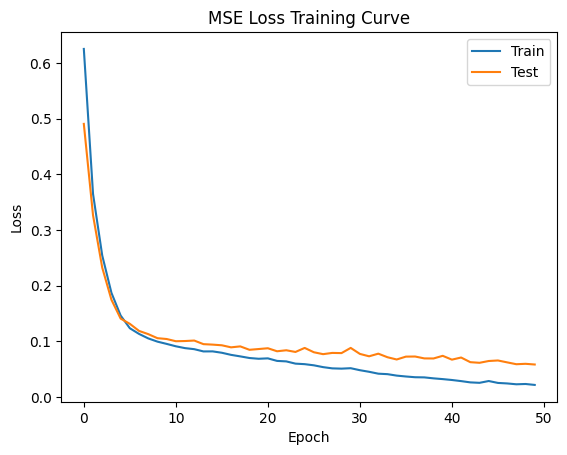

In [ ]:
plt.plot(hist_train, label='Train')
plt.plot(hist_test, label='Test')
# set y label
plt.title('MSE Loss Training Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.yscale('log')
plt.show()

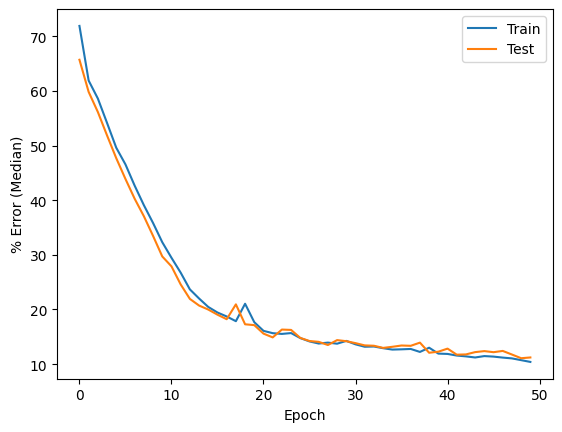

Final training error: 10.405%
Final test error: 11.220%


In [ ]:
plt.plot(meds_train, label='Train')
plt.plot(meds_test, label='Test')
plt.ylabel('% Error (Median)')
plt.xlabel('Epoch')

plt.legend()
# plt.yscale('log')
plt.show()

print("Final training error: {:.3f}%".format(meds_train[-1]))
print("Final test error: {:.3f}%".format(meds_test[-1]))

## Results!

downloading pre-trained model weights

In [ ]:
!gdown 1UQAjyMA4cThsv7-fDO_nt7tb3AZR2kyd

Downloading...
From: https://drive.google.com/uc?id=1UQAjyMA4cThsv7-fDO_nt7tb3AZR2kyd
To: /content/CarbonReductionCNN.pth
100% 287M/287M [00:04<00:00, 67.3MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CarbonReductionCNN()
model.to(device)

state_dict = torch.load('CarbonReductionCNN.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

Evaluating model

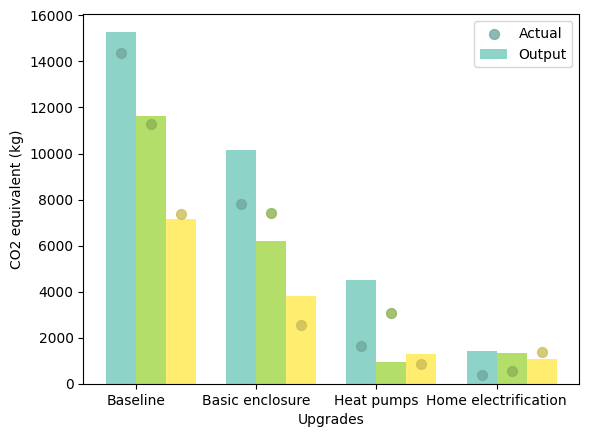

In [ ]:
num_results = 3
results_data = DataLoader(test_dataset, batch_size=num_results, shuffle=True)

for x1_batch, x2_batch, y_batch in results_data:
    outputs = model(x1_batch, x2_batch)
    y_batch = y_batch.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    break

out = np.zeros((3, 11))
out[:, 0] = outputs[:, 0] + outputs[:, 1]
for i in range(10):
    out[:, i+1] = outputs[:, (4 * i+2)] + outputs[:, (4 * i+3)]

y_out = np.zeros((3, 11))
y_out[:, 0] = y_batch[:, 0] + y_batch[:, 1]
for i in range(10):
    y_out[:, i+1] = y_batch[:, (4 * i+2)] + y_batch[:, (4 * i+3)]

out = out[:, [0, 1, 4, 10]]
y_out = y_out[:, [0, 1, 4, 10]]

out = out * np.std(Y) + np.mean(Y)
y_out = y_out * np.std(Y) + np.mean(Y)


pos = np.arange(out.shape[1])
bar_width = 0.25

# Use the Set3 colormap for pastel colors
colormap = cm.Set3
colors = colormap(np.linspace(0, 1, out.shape[0]))
marker_colors = colors * 0.8  # Darken the colors for markers

# Plotting the bars
fig, ax = plt.subplots()

for i in range(out.shape[0]):
    ax.bar(pos + i * bar_width, abs(out[i]), bar_width, color=colors[i], label=f'Output' if i == 0 else None)

# Overlaying y_out as markers
for i in range(y_out.shape[0]):
    ax.scatter(pos + i * bar_width, abs(y_out[i]), color=marker_colors[i], marker='o', s=50, zorder=5, label=f'Actual' if i == 0 else None)

# Adding labels and title
ax.set_xlabel('Upgrades')
ax.set_ylabel('CO2 equivalent (kg)')
ax.set_xticks(pos + bar_width / 2)
ax.set_xticklabels([f'{i}' for i in range(out.shape[1])])
ax.set_xticklabels(['Baseline', 'Basic enclosure', 'Heat pumps', 'Home electrification'])

ax.legend()

# Displaying the plot
plt.show()

In [ ]:
model.eval()
run = 0
with torch.no_grad():
    for x1_batch, x2_batch, y_batch in test_loader:
        outputs = model(x1_batch, x2_batch)
        run += mean_abs_error(outputs, y_batch).item()

print(run / len(test_loader), 'kg CO2eq')

5503.214111328125 kg CO2eq


In [ ]:
outputs_in = outputs * torch.std(torch_y) + torch.mean(torch_y)
result = torch.abs(money_savings(outputs_in[:2, :])).tolist()

formatted_result = []
for i, sublist in enumerate(result):
    formatted_sublist = []
    for j, num in enumerate(sublist):
        formatted_num = '${:,.2f}'.format(num)
        formatted_sublist.append(f'Example {i+1}, Upgrade {j}: {formatted_num}')
    formatted_result.append(formatted_sublist)

for sublist in formatted_result:
    for item in sublist:
        print(item)

Example 1, Upgrade 0: $196.43
Example 1, Upgrade 1: $559.65
Example 1, Upgrade 2: $2,484.02
Example 1, Upgrade 3: $2,324.29
Example 1, Upgrade 4: $1,347.26
Example 1, Upgrade 5: $2,841.83
Example 1, Upgrade 6: $2,830.04
Example 1, Upgrade 7: $1,036.88
Example 1, Upgrade 8: $1,073.39
Example 2, Upgrade 0: $638.95
Example 2, Upgrade 1: $1,264.54
Example 2, Upgrade 2: $1,128.78
Example 2, Upgrade 3: $749.25
Example 2, Upgrade 4: $937.73
Example 2, Upgrade 5: $2,072.68
Example 2, Upgrade 6: $2,037.91
Example 2, Upgrade 7: $766.23
Example 2, Upgrade 8: $803.55
